## tutorials
- [audio data processing](https://www.youtube.com/watch?v=ZqpSb5p1xQo&ab_channel=MedallionDataScience)

## key concepts 
1.  **frequency** (Hz): wavelength
    1.  high frequency = high pitch
2.  **intensity** (db/power): amplitude of waves 
    1.  high intensity = loudness
3.  **sample rate**: sound is continuous, but we can only process discrete data. how many times per second we get a value. The unit is Hz. The sample rate needs to be at least double of the highest frequency in the original sound, otherwise, you get aliasing. 
    1.  high sample rate = high resolution = high quality = more details 
    2.  **Aliasing** occurs when a signal is undersampled. If the signal sampling rate is too low, we get frequency-domain aliasing.

In [36]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import Audio
from glob import glob # display filed in a dir

import librosa
import librosa.display

import soundfile as sf
import parselmouth
#import myprosody as mysp # Audio files must be in *.wav format, recorded at 48 kHz sample frame and 24-32 bits of resolution.

sb.set_theme(style="white") # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook

## check for audio stat - convert

In [37]:
# import and inspect sound file with soundfile pkg
raw = sf.SoundFile('sound/sample.wav')
print('Sample rate: {}'.format(raw.samplerate))  
print('Channels: {}'.format(raw.channels)) # usually 2, 1 right + 1 left speakers
print('Subtype: {}'.format(raw.subtype)) # Dynamic range is the difference between the quietest and loudest volume of an instrument. A bit-depth of 16 bit has a theoretical dynamic range of 96 dB, whereas 24 bit has a dynamic range of 144 dB. PCM_16 means 16 bit depth, where PCM stands for Pulse-Code Modulation.

Sample rate: 48000
Channels: 2
Subtype: PCM_16


In [38]:
# convert to desired format (sample rate = 48000, dynamic range  = 24 bit depth)
data, samplerate = sf.read('sound/sample.wav')
sf.write('sound/new.wav',data, samplerate, subtype='PCM_24')

## processing data

In [39]:
# read audio file and check if it is the right one
data, sr = librosa.load("sound/new.wav")

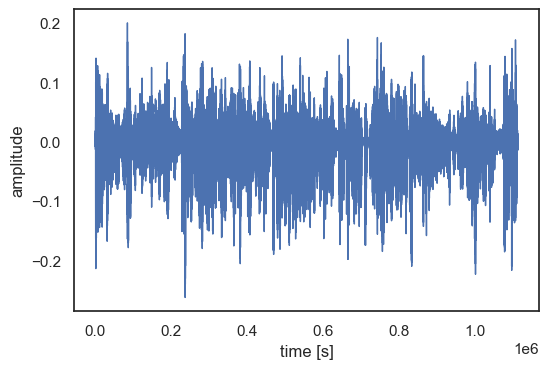

In [40]:
pd.Series(data).plot(lw=1)
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

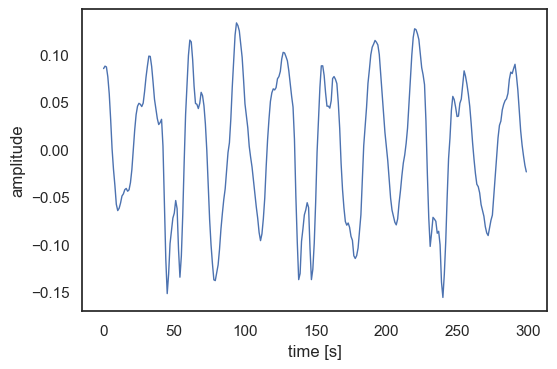

In [42]:
# zoom in 
pd.Series(data[3000:3300]).plot(lw=1)
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

## spectogram (using fft)

- The Fourier transform is a mathematical formula that allows us to decompose a signal into its individual frequencies and the frequency’s amplitude. It converts the signal from the time domain into the frequency domain. The result is called a spectrum.
- FFT = fast fourier trasformation 
- the frequency of speech or music sound signals that vary over time is known as non-periodic signals. So we use a short-time Fourier transform for each segment of sound signal.
- A spectrogram as a bunch of FFTs stacked on top of each other [sources](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53)

### implementing stft in python
- **window size** = perform stft on each window. It is the envelope of each filter's impulse response.
- **hop size** = the portion of time window that was not overlapped 
- overlapping time window 
- **why overlap time window?** Any tapering function used is almost always decreasing to zero at boundaries. So if the window is not overlapped, we will lose some data at the junction. [source](https://dsp.stackexchange.com/questions/19311/stft-why-overlapping-the-window)
- choice of hop size: [source](https://ccrma.stanford.edu/~jos/parshl/Choice_Hop_Size.html)



In [43]:
# short term fourier transform
frame_size = 2048
hop_size = 512

# default n_fft=2048
# default win_length = n_fft
# # default hop_length = win_length // 4
d = librosa.stft(data, n_fft=frame_size, hop_length=hop_size)

# convert amplitude to db
s_db=librosa.amplitude_to_db(np.abs(d), ref = np.max)
s_db.shape

(1025, 2175)

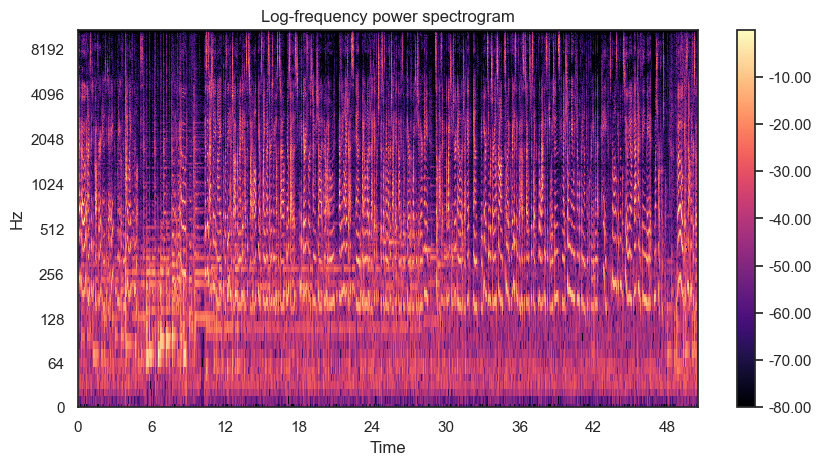

In [35]:
# plot the transformed audio data
fig, ax = plt.subplots(figsize = (10,5))

img = librosa.display.specshow(s_db, x_axis = 'time', y_axis='log', ax=ax)
# ax=axmatplotlib.axes axes to plot on by color, color is db
ax.set(title = "Log-frequency power spectrogram")
ax.label_outer()
fig.colorbar(img, ax=ax, format=f'%0.2f') #2 decimals to floating point type, https://pyformat.info/

## Mel spectrogram

- Humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than in higher frequencies. JND is smaller in lower frequency (Hz) than in higher frequency. This is done by psychoacoustic experiment
- mel scale (mel is the first three syllabi of melody) is the perceptual scale for pitch. It is a log scale. The frequency can be expressed in Hz but also mel. A unit of increase in mel is equal perceptually in each position on the mel scale. E.g.,  for human, the increase from 2 to 3 mel is the same as 3 to 4 mel
- x=frequency in log(hz), y = frequency in mel
- 1000 Hz = 1000 Mel
- mapped the y-axis (frequency) onto the mel scale to form the mel spectrogram.



In [31]:
mel_s = librosa.feature.melspectrogram(data, sr=sr, n_mels = 128)
mel_s.shape

mel_s_db = librosa.amplitude_to_db(mel_s, ref=np.max)


array([[-80.      , -79.76286 , -73.49095 , ..., -65.0164  , -74.5119  ,
        -60.495125],
       [-80.      , -72.88772 , -67.74833 , ..., -49.756134, -51.888206,
        -49.675964],
       [-80.      , -72.985306, -63.2882  , ..., -50.421413, -60.87217 ,
        -62.01457 ],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

# plot the mel spectrogram
img = librosa.display.specshow(mel_s_db, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel spectrogram')
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

## Frequency-domain features
- **band energy ratio** (BER): the comparison of energy in the lower/higher energy band. It's a measure of how dominant low frequencies are in a sound.
   -  sum of the power (magnitude of the signal) in a lower frequency band (n) / sum of the power in the higher frequency band at a specific time frame
   -  split frequency is the threshold that split high vs lower frequency (arbitrary, usually 2000Hz)
   -  used for music vs speech discrimination
   -  music genre classification

<img src="img/ber.png" width="200">

-  **spectral centroid** (SC): center of gravity of the magnitude spectrum. It is a frequency band where most of the energy is concentrated. It is a measure of the brightness of sounds (timbre of the sound)
   -  weighted mean of the frequencies
   -  audio and music classification
-  **bandwidth** (BW, aka spectral spread): spectral range around the centroid (relevant to the perceived timbre)
   -  weighted mean of the distances of the frequency band from SC (variance of energy)

## Speech sound
- **Glottis**:  a flap in the throat near vocal folds

<img src = "img/glottis.jpeg" width="200">

- **phonation**: the process by which the vocal folds produce certain sounds through quasi-periodic vibration. Phonology encompasses the rules of the sound system of language.
- **Articulation** is the correct movement of the speech producers to make intelligible speech. 
- **prosody**: the patterns of stress and intonation in a language.